# WaterToC Model Sensitivity Analysis
This notebook provides comprehensive sensitivity analysis for the WaterToC Mesa model using One-at-a-Time (OAT), Sobol, and Kolmogorov-Smirnov methods.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Import our sensitivity analysis module
from sensitivity_analysis import WaterToCeSensitivityAnalyzer

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Initialize the sensitivity analyzer
analyzer = WaterToCeSensitivityAnalyzer(
    n_runs_per_config=100,  # Number of replications per configuration
    max_steps=100,         # Model steps per run
    n_jobs=10              # Parallel processing
)

print("Sensitivity Analyzer Configuration:")
print(f"Parameter bounds: {analyzer.param_bounds}")
print(f"Baseline parameters: {analyzer.baseline_params}")
print(f"Output metrics: {analyzer.output_metrics}")

Sensitivity Analyzer Configuration:
Parameter bounds: {'initial_humans': [5, 20], 'initial_ai': [5, 20], 'C_Payoff': [0.1, 1.0], 'D_Payoff': [0.5, 2.0], 'max_water_capacity': [5, 15], 'water_cell_density': [0.2, 0.5], 'theta': [1.0, 10.0]}
Baseline parameters: {'initial_humans': 10, 'initial_ai': 10, 'C_Payoff': 0.5, 'D_Payoff': 1.0, 'max_water_capacity': 10, 'water_cell_density': 0.3, 'theta': 3.0}
Output metrics: ['final_coop_fraction', 'final_environment_state', 'final_total_water', 'avg_coop_fraction', 'avg_environment_state', 'water_depletion_rate', 'stability_index']


**One-at-a-Time (OAT) Sensitivity Analysis**

In [3]:
# Run OAT sensitivity analysis
print("Running One-at-a-Time Sensitivity Analysis...")
oat_results = analyzer.oat_sensitivity_analysis(n_samples=10)

# Create summary of OAT results
oat_summary = []
for param_name, results in oat_results.items():
    for metric in analyzer.output_metrics:
        if metric in results['effects']:
            oat_summary.append({
                'Parameter': param_name,
                'Metric': metric,
                'Range': results['effects'][metric]['range'],
                'Correlation': results['effects'][metric]['correlation'],
                'Std': results['effects'][metric]['std']
            })

oat_df = pd.DataFrame(oat_summary)
print("OAT Analysis Complete!")
print(oat_df.head(10))

Running One-at-a-Time Sensitivity Analysis...
Running OAT Sensitivity Analysis...
Analyzing parameter: initial_humans
Running configuration 1/10
Running configuration 2/10
Running configuration 3/10
Running configuration 4/10
Running configuration 5/10
Running configuration 6/10
Running configuration 7/10
Running configuration 8/10
Running configuration 9/10
Running configuration 10/10
Analyzing parameter: initial_ai
Running configuration 1/10
Running configuration 2/10
Running configuration 3/10
Running configuration 4/10
Running configuration 5/10
Running configuration 6/10
Running configuration 7/10
Running configuration 8/10
Running configuration 9/10
Running configuration 10/10
Analyzing parameter: C_Payoff
Running configuration 1/10
Running configuration 2/10
Running configuration 3/10
Running configuration 4/10
Running configuration 5/10
Running configuration 6/10
Running configuration 7/10
Running configuration 8/10
Running configuration 9/10
Running configuration 10/10
Analyzi

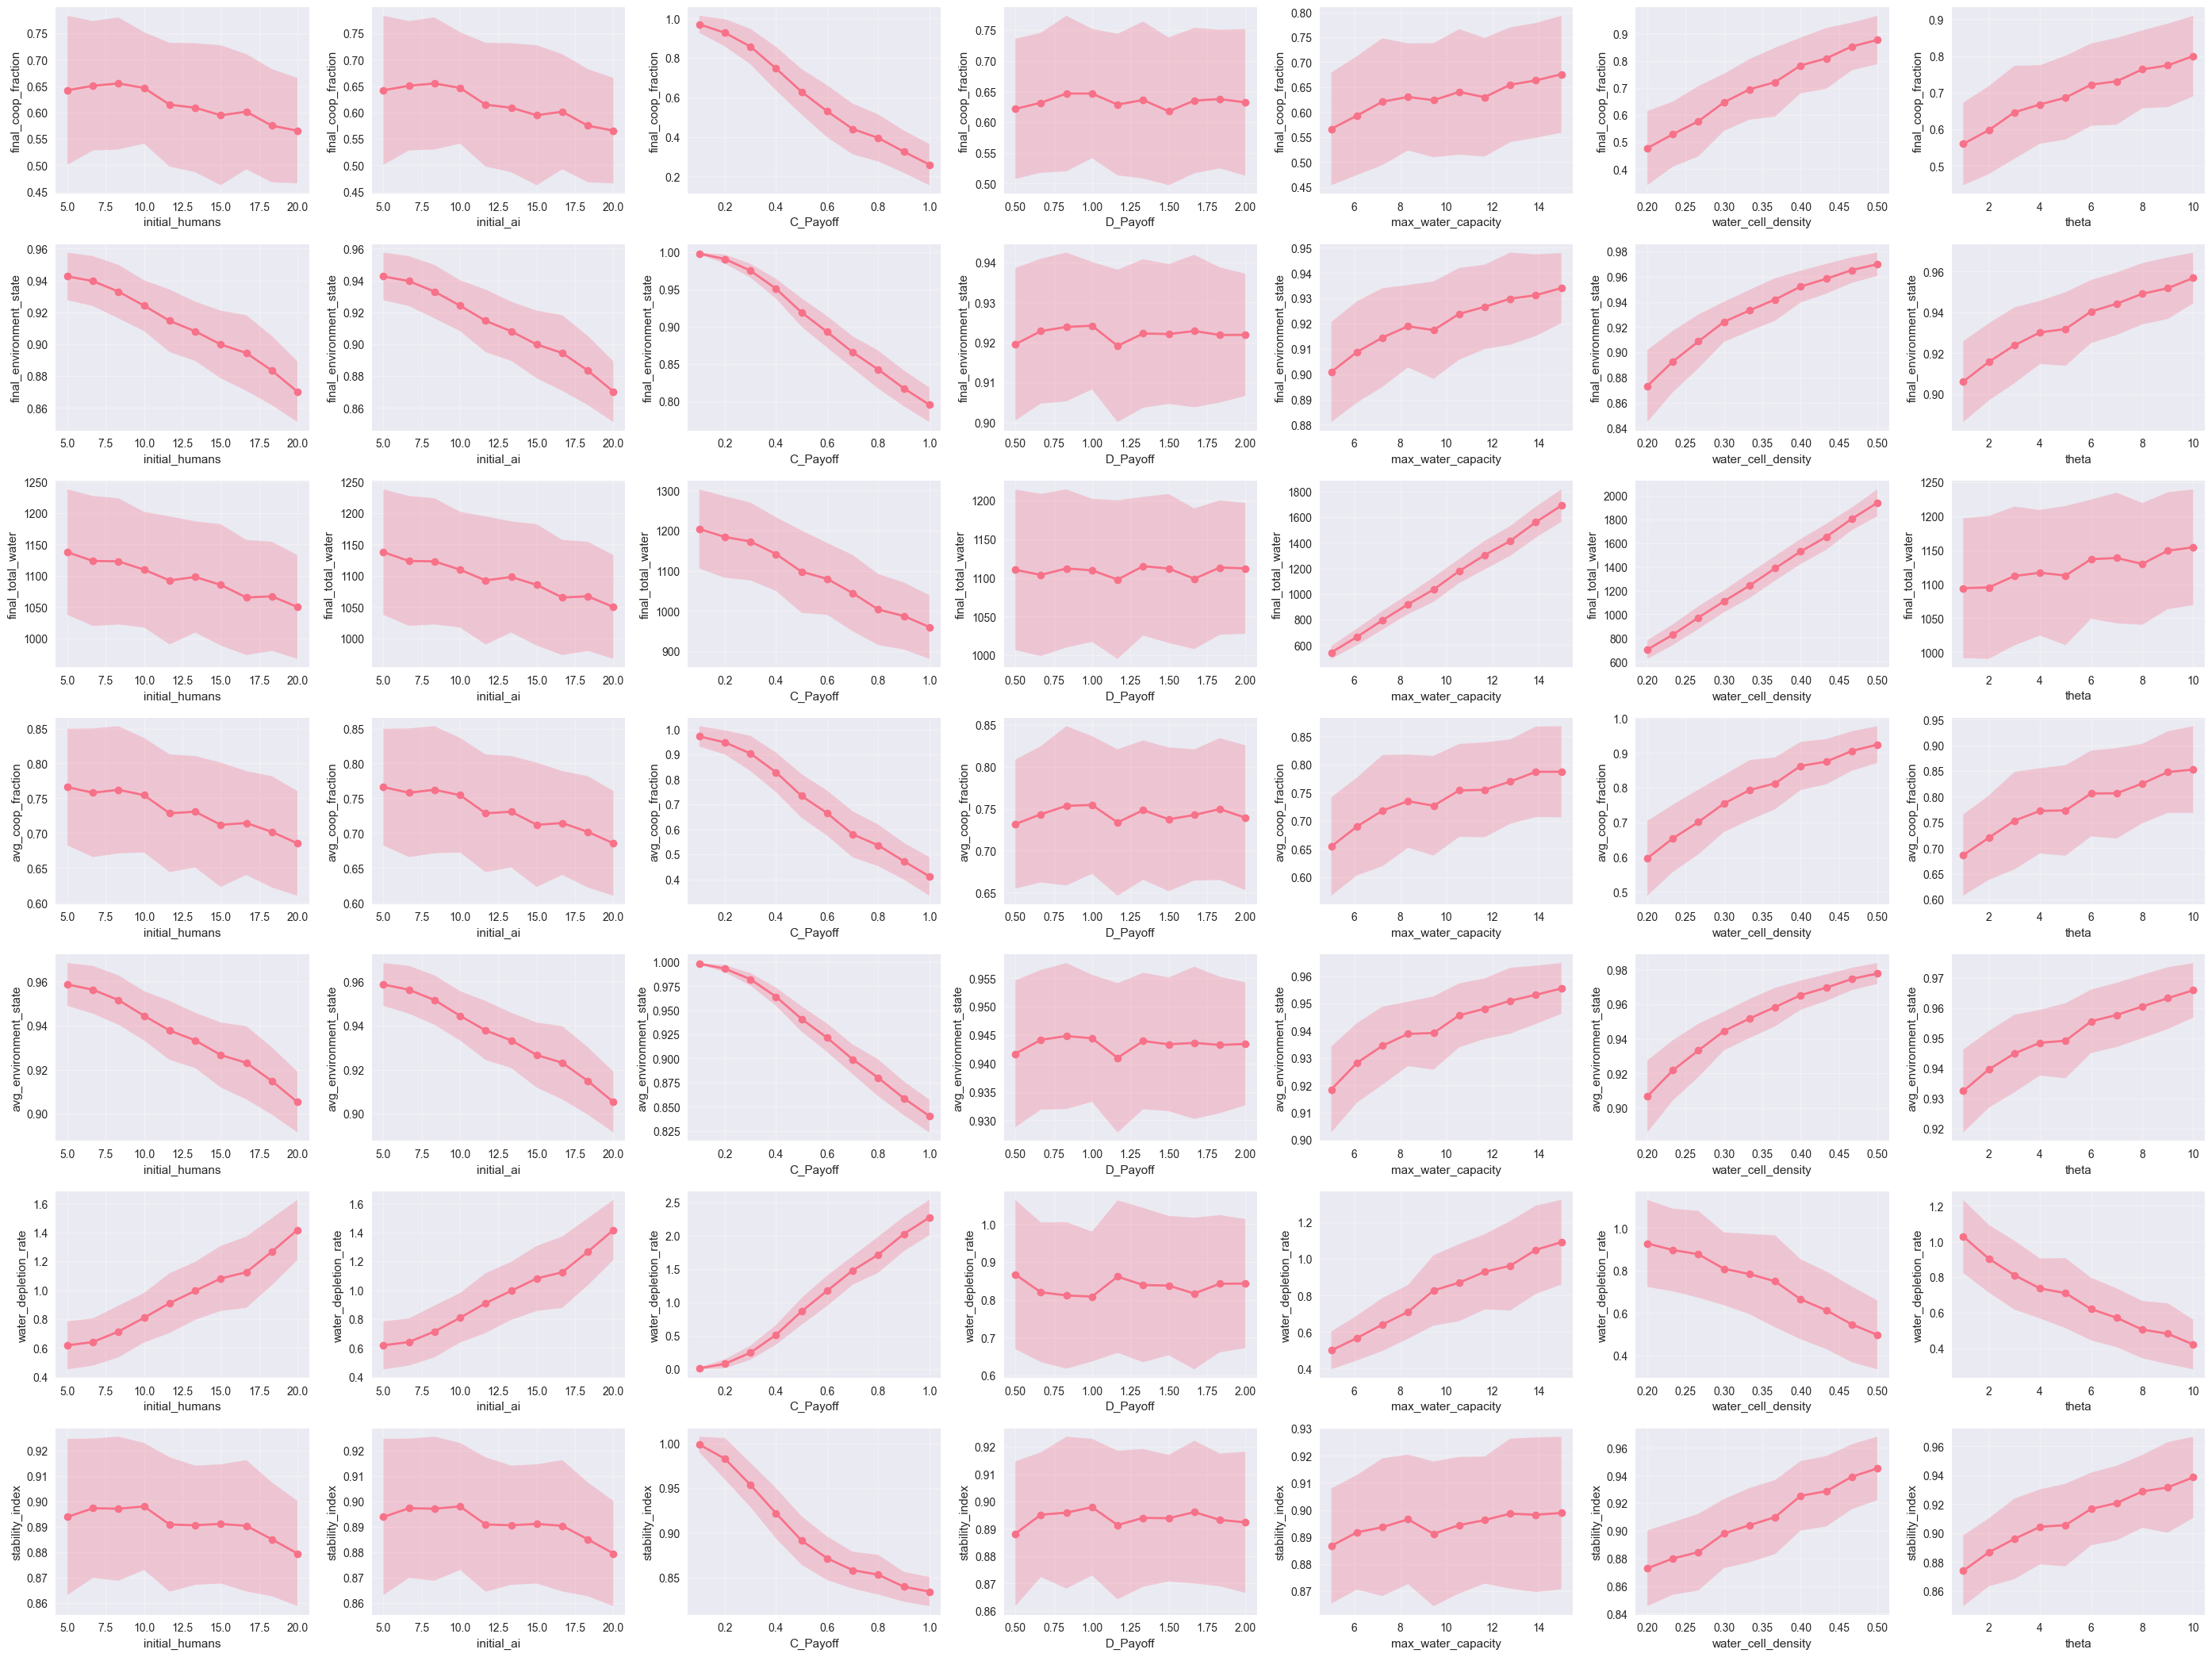

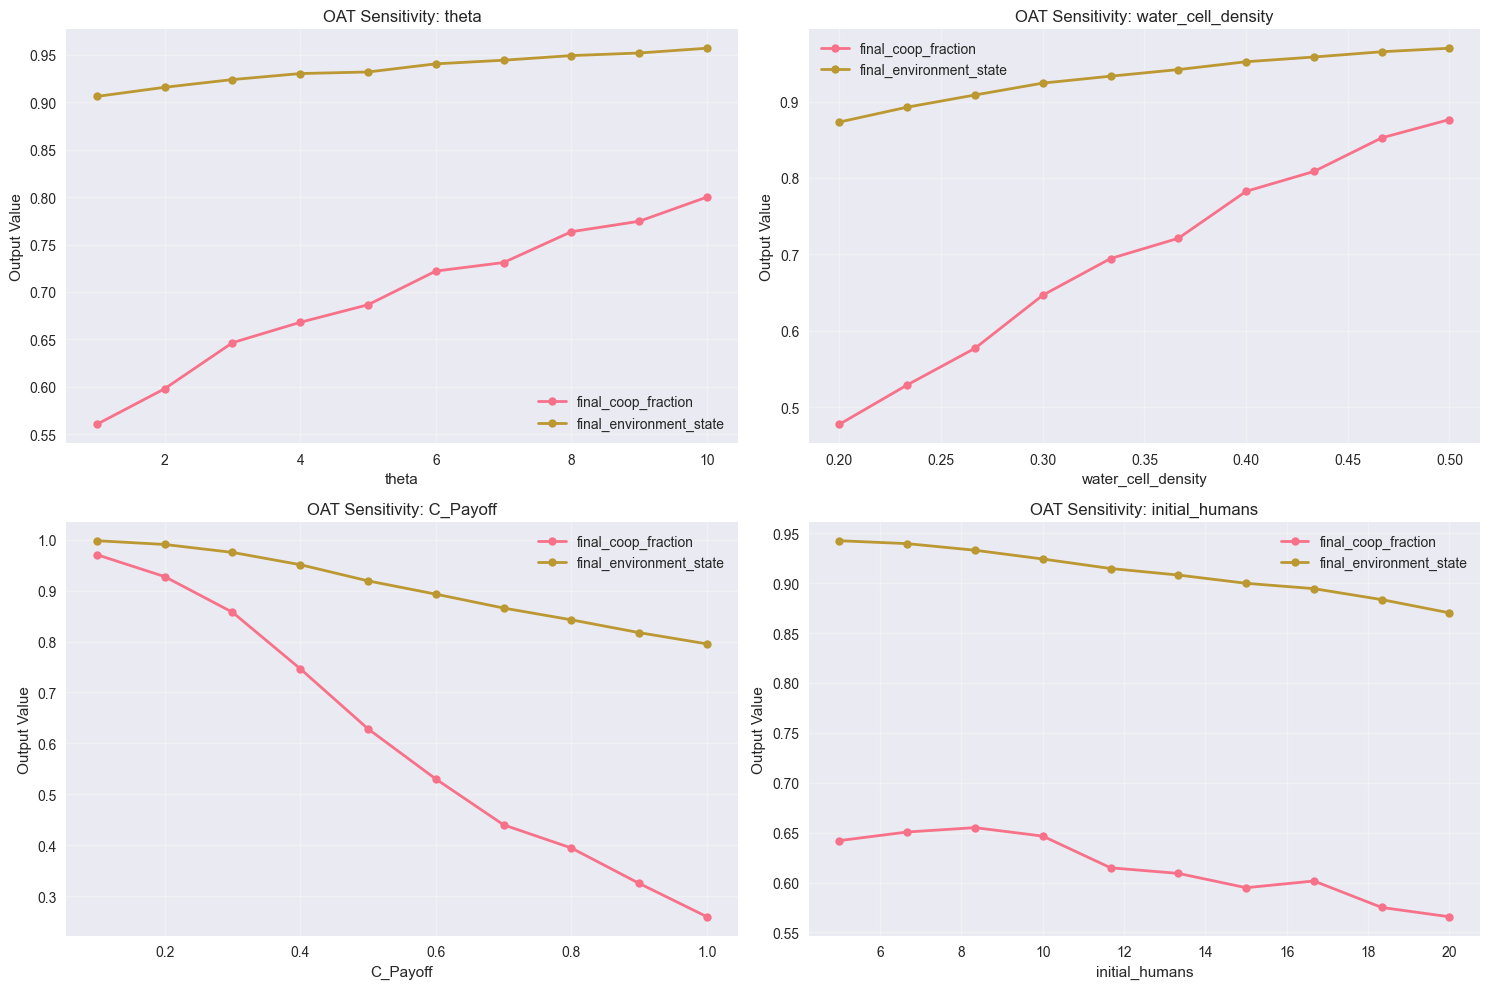

In [4]:
# Plot OAT sensitivity results
analyzer.plot_oat_results(oat_results)

# Create focused plots for key parameters and metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

key_params = ['theta', 'water_cell_density', 'C_Payoff', 'initial_humans']
key_metrics = ['final_coop_fraction', 'final_environment_state']

for i, param in enumerate(key_params):
    ax = axes[i//2, i%2]
    
    if param in oat_results:
        data = oat_results[param]['data']
        
        for metric in key_metrics:
            if metric in data.columns:
                grouped = data.groupby(param)[metric].mean()
                ax.plot(grouped.index, grouped.values, 'o-', 
                       label=metric, linewidth=2, markersize=6)
        
        ax.set_xlabel(param)
        ax.set_ylabel('Output Value')
        ax.set_title(f'OAT Sensitivity: {param}')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Parameter Ranking by OAT Sensitivity (Key Outputs):
            Parameter  Avg_Abs_Correlation
2            C_Payoff             0.934337
5  water_cell_density             0.794098
6               theta             0.577264
1          initial_ai             0.433509
0      initial_humans             0.433509
4  max_water_capacity             0.377369
3            D_Payoff             0.003553


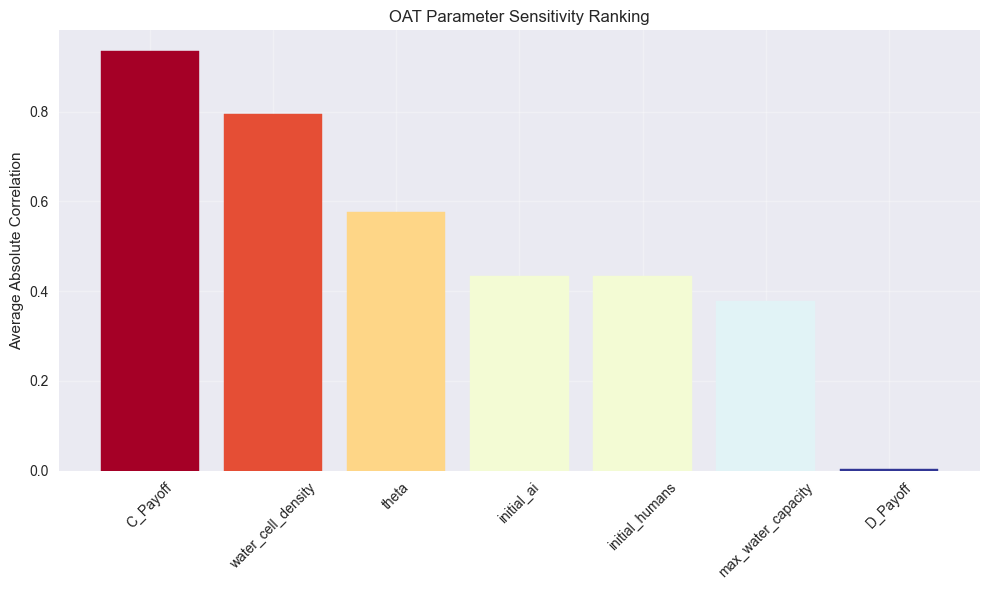

In [5]:
# Rank parameters by sensitivity (using correlation with key outputs)
key_outputs = ['final_coop_fraction', 'final_environment_state', 'avg_coop_fraction']

param_rankings = []
for param_name, results in oat_results.items():
    total_correlation = 0
    count = 0
    
    for metric in key_outputs:
        if metric in results['effects']:
            total_correlation += abs(results['effects'][metric]['correlation'])
            count += 1
    
    avg_correlation = total_correlation / count if count > 0 else 0
    param_rankings.append({
        'Parameter': param_name,
        'Avg_Abs_Correlation': avg_correlation
    })

ranking_df = pd.DataFrame(param_rankings).sort_values('Avg_Abs_Correlation', ascending=False)

print("Parameter Ranking by OAT Sensitivity (Key Outputs):")
print(ranking_df)

# Visualize parameter rankings
plt.figure(figsize=(10, 6))
bars = plt.bar(ranking_df['Parameter'], ranking_df['Avg_Abs_Correlation'])
plt.xticks(rotation=45)
plt.ylabel('Average Absolute Correlation')
plt.title('OAT Parameter Sensitivity Ranking')
plt.grid(True, alpha=0.3)

# Color bars by sensitivity level
colors = plt.cm.RdYlBu_r(ranking_df['Avg_Abs_Correlation'] / ranking_df['Avg_Abs_Correlation'].max())
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.tight_layout()
plt.show()

**Sobol Global Sensitivity Analysis**

In [8]:
# Run Sobol sensitivity analysis
print("Running Sobol Global Sensitivity Analysis...")
sobol_results = analyzer.sobol_sensitivity_analysis(n_samples=10)

# Extract and display Sobol indices
sobol_indices = sobol_results['sobol_indices']
problem = sobol_results['problem']

print("Sobol Analysis Complete!")
print("Sample of Sobol indices:")

for metric in ['final_coop_fraction', 'final_environment_state']:
    if metric in sobol_indices and sobol_indices[metric] is not None:
        print(f"\n{metric}:")
        print("First-order indices (S1):")
        for i, param in enumerate(problem['names']):
            s1 = sobol_indices[metric]['S1'][i]
            print(f"  {param}: {s1:.3f}")

Running Sobol Global Sensitivity Analysis...
Running Sobol Sensitivity Analysis...
Running configuration 1/160
Running configuration 2/160
Running configuration 3/160
Running configuration 4/160
Running configuration 5/160
Running configuration 6/160
Running configuration 7/160
Running configuration 8/160
Running configuration 9/160
Running configuration 10/160
Running configuration 11/160
Running configuration 12/160
Running configuration 13/160
Running configuration 14/160
Running configuration 15/160
Running configuration 16/160
Running configuration 17/160
Running configuration 18/160
Running configuration 19/160
Running configuration 20/160
Running configuration 21/160
Running configuration 22/160
Running configuration 23/160
Running configuration 24/160
Running configuration 25/160
Running configuration 26/160
Running configuration 27/160
Running configuration 28/160
Running configuration 29/160
Running configuration 30/160
Running configuration 31/160
Running configuration 32/16

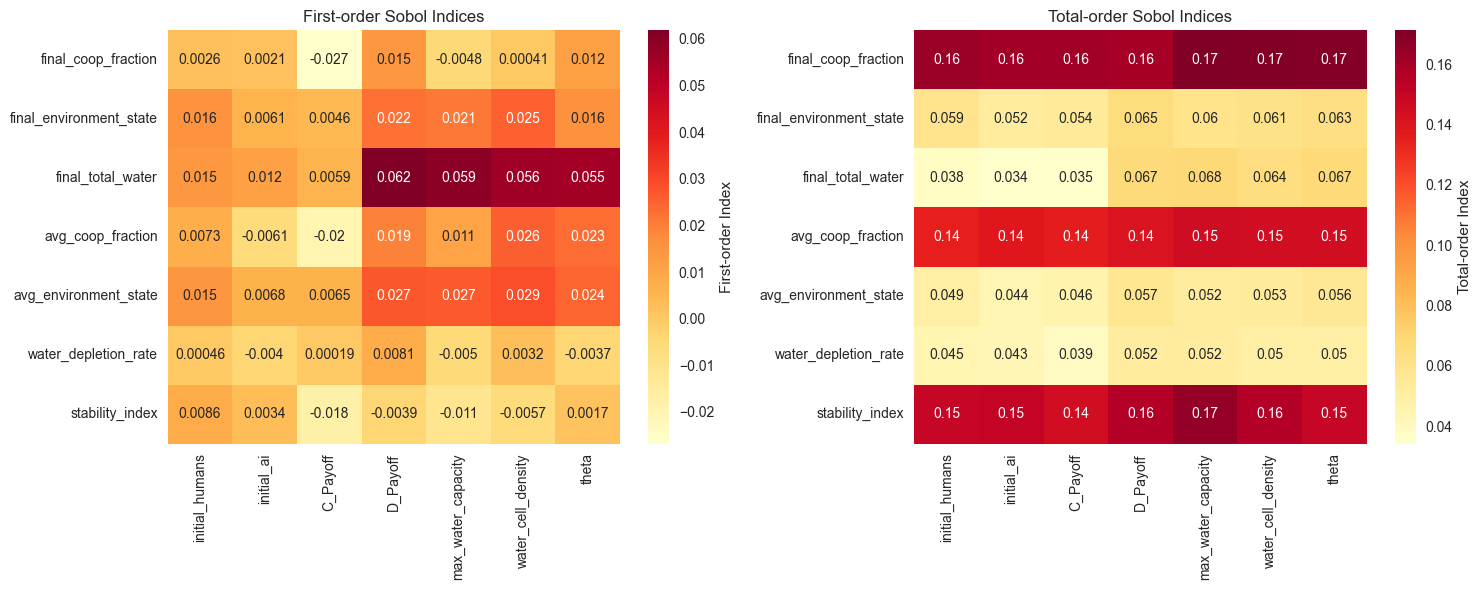

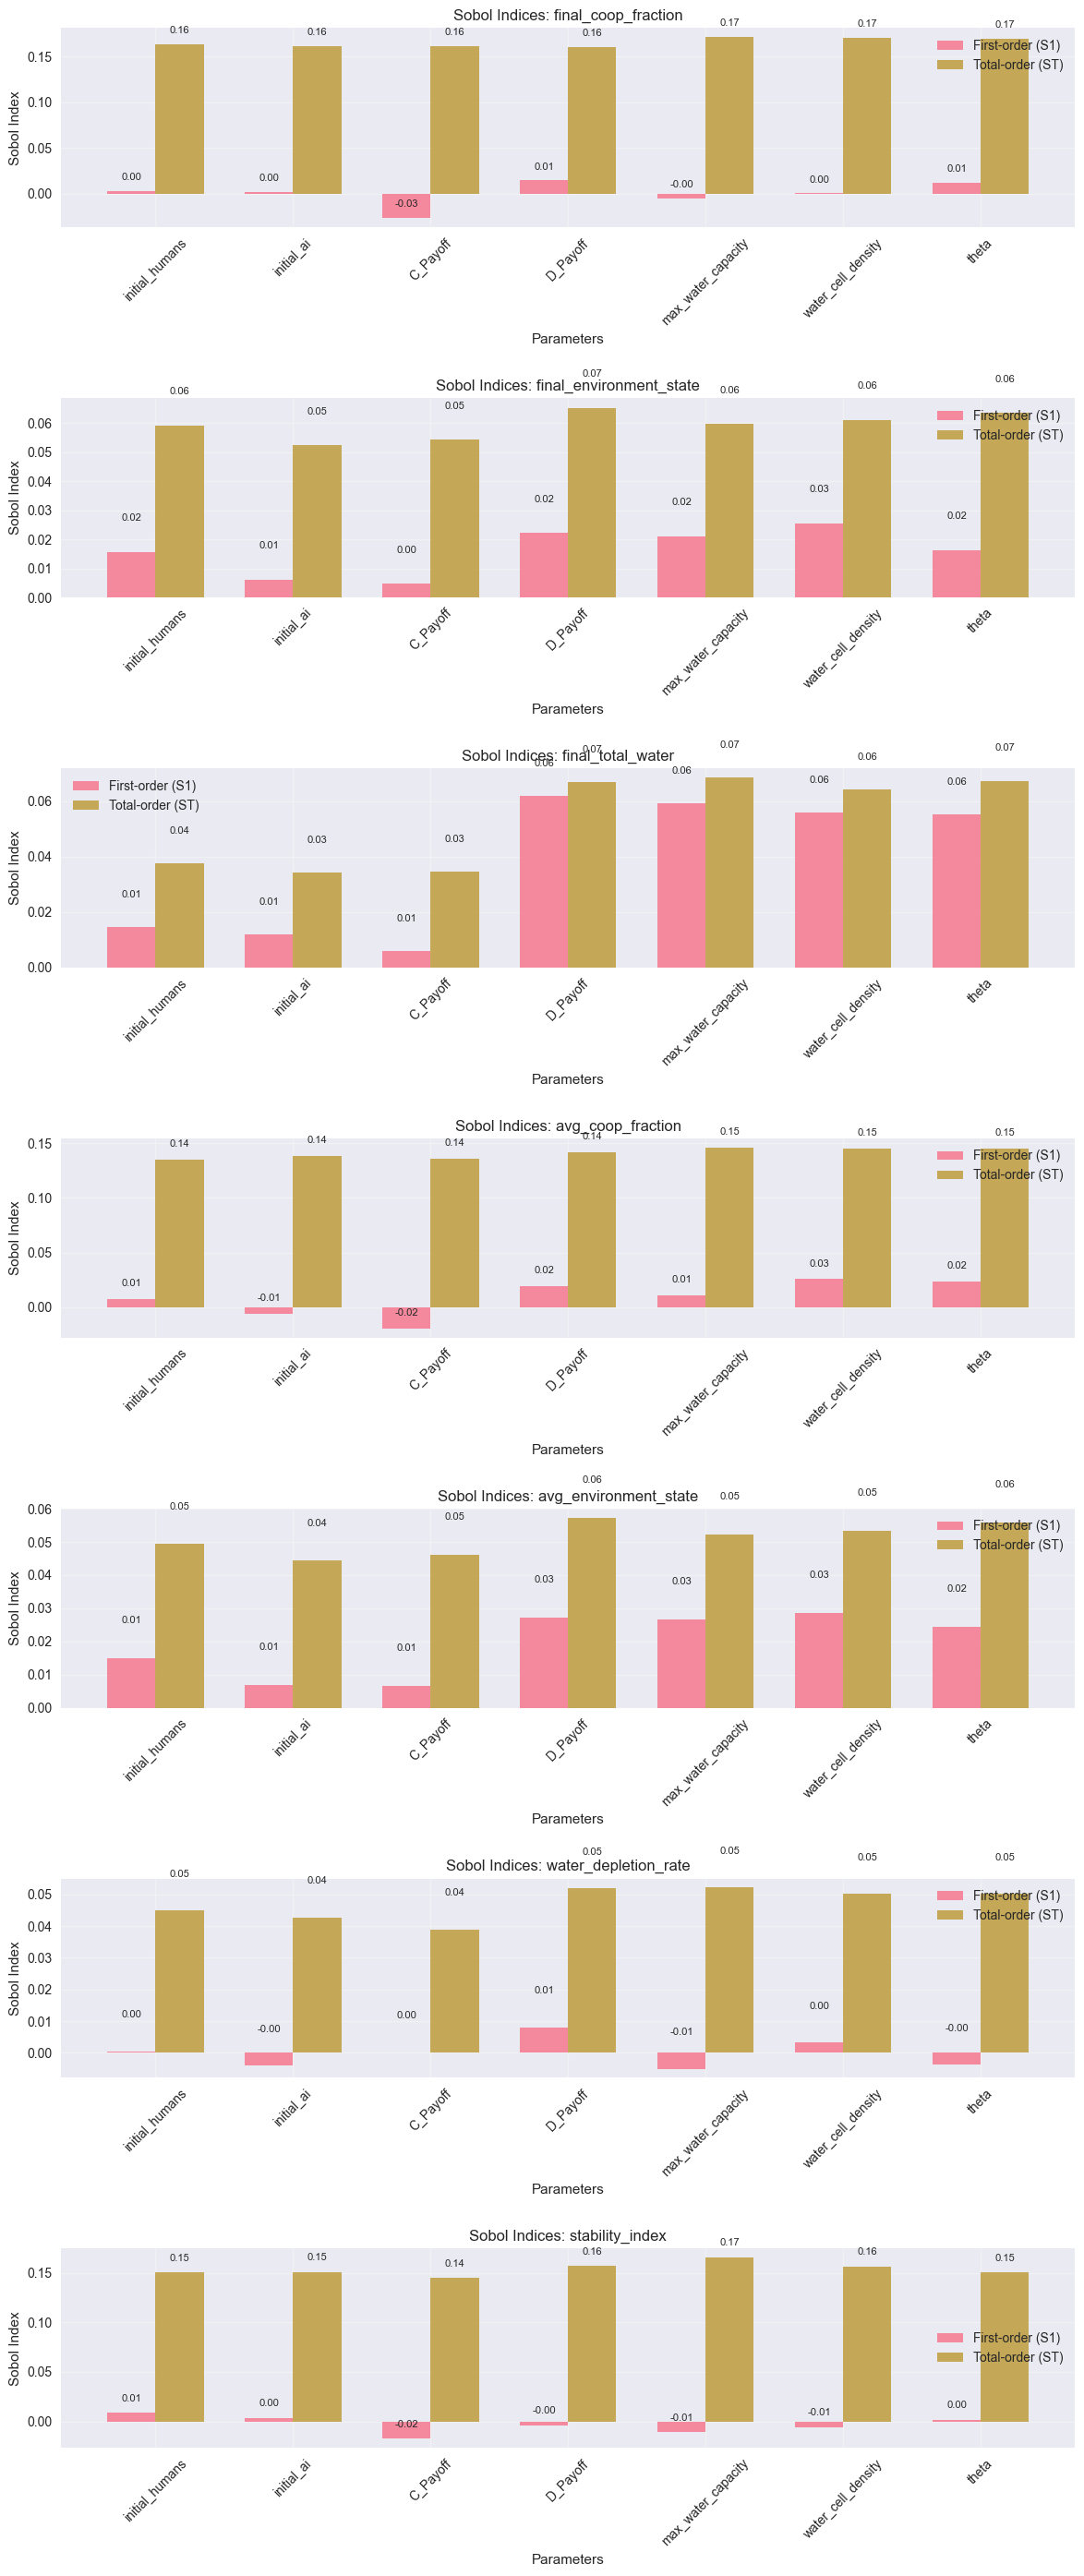

In [9]:
# Plot Sobol sensitivity results
analyzer.plot_sobol_results(sobol_results)

# Create detailed Sobol comparison plot
metrics_with_data = [m for m in analyzer.output_metrics 
                    if m in sobol_indices and sobol_indices[m] is not None]

if metrics_with_data:
    fig, axes = plt.subplots(len(metrics_with_data), 1, figsize=(12, 4*len(metrics_with_data)))
    
    if len(metrics_with_data) == 1:
        axes = [axes]
    
    for i, metric in enumerate(metrics_with_data):
        ax = axes[i]
        
        s1 = sobol_indices[metric]['S1']
        st = sobol_indices[metric]['ST']
        
        x = np.arange(len(problem['names']))
        width = 0.35
        
        bars1 = ax.bar(x - width/2, s1, width, label='First-order (S1)', alpha=0.8)
        bars2 = ax.bar(x + width/2, st, width, label='Total-order (ST)', alpha=0.8)
        
        ax.set_xlabel('Parameters')
        ax.set_ylabel('Sobol Index')
        ax.set_title(f'Sobol Indices: {metric}')
        ax.set_xticks(x)
        ax.set_xticklabels(problem['names'], rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=8)
        
        for bar in bars2:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

Sobol Parameter Ranking (by average Total-order index):
                          ST        S1  Interaction
Parameter                                          
max_water_capacity  0.102189  0.013795     0.088394
theta               0.100342  0.018372     0.081970
water_cell_density  0.100182  0.019089     0.081093
D_Payoff            0.100022  0.021329     0.078693
initial_humans      0.091457  0.009164     0.082293
initial_ai          0.089206  0.002889     0.086317
C_Payoff            0.088072 -0.006666     0.094738


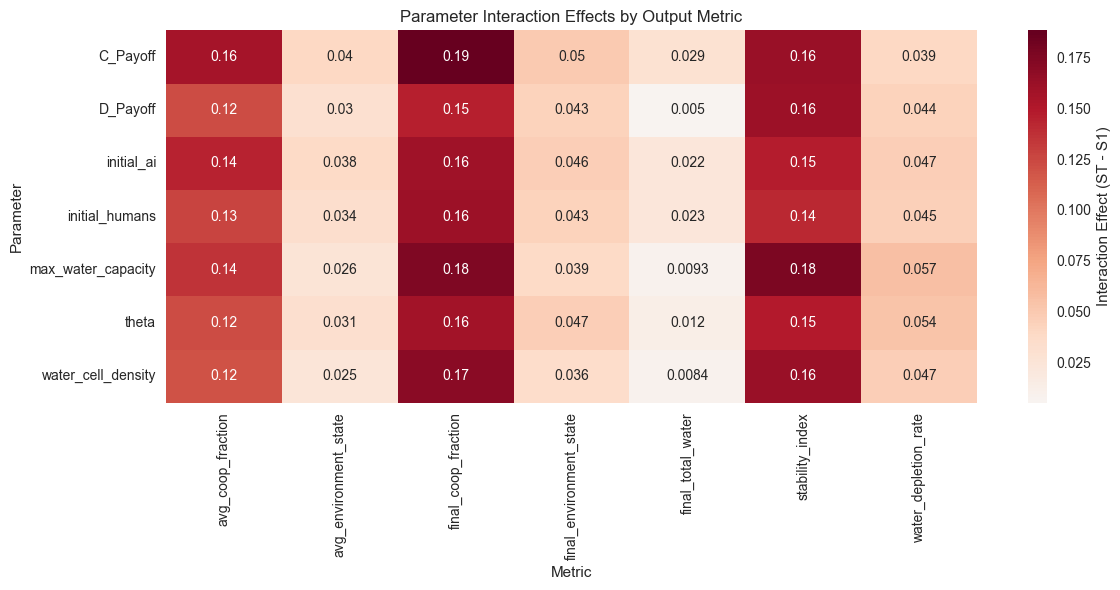

In [10]:
# Create Sobol parameter ranking
sobol_rankings = []

for metric in metrics_with_data:
    st_indices = sobol_indices[metric]['ST']
    s1_indices = sobol_indices[metric]['S1']
    
    for i, param in enumerate(problem['names']):
        sobol_rankings.append({
            'Parameter': param,
            'Metric': metric,
            'S1': s1_indices[i],
            'ST': st_indices[i],
            'Interaction': st_indices[i] - s1_indices[i]  # Measure of interaction effects
        })

sobol_df = pd.DataFrame(sobol_rankings)

# Overall parameter ranking based on total-order indices
overall_sobol_ranking = sobol_df.groupby('Parameter').agg({
    'ST': 'mean',
    'S1': 'mean',
    'Interaction': 'mean'
}).sort_values('ST', ascending=False)

print("Sobol Parameter Ranking (by average Total-order index):")
print(overall_sobol_ranking)

# Visualize interaction effects
plt.figure(figsize=(12, 6))
pivot_interaction = sobol_df.pivot(index='Parameter', columns='Metric', values='Interaction')
sns.heatmap(pivot_interaction, annot=True, cmap='RdBu_r', center=0,
           cbar_kws={'label': 'Interaction Effect (ST - S1)'})
plt.title('Parameter Interaction Effects by Output Metric')
plt.tight_layout()
plt.show()

**Kolmogorov-Smirnov (KS) Sensitivity Analysis**

In [12]:
# Run KS sensitivity analysis
print("Running Kolmogorov-Smirnov Sensitivity Analysis...")
ks_results = analyzer.ks_sensitivity_analysis(n_samples=100, n_perturbations=10)

# Create KS summary
ks_summary = []
for param_name, results in ks_results.items():
    for metric, ks_test in results['ks_tests'].items():
        ks_summary.append({
            'Parameter': param_name,
            'Metric': metric,
            'KS_Statistic': ks_test['ks_statistic'],
            'P_Value': ks_test['p_value'],
            'Significant': ks_test['significant']
        })

ks_df = pd.DataFrame(ks_summary)
print("KS Analysis Complete!")
print(ks_df.head(10))

# Show significant effects
significant_effects = ks_df[ks_df['Significant'] == True]
print(f"\nSignificant effects (p < 0.05): {len(significant_effects)}")
print(significant_effects.sort_values('KS_Statistic', ascending=False))

Running Kolmogorov-Smirnov Sensitivity Analysis...
Running KS Sensitivity Analysis...
Running configuration 1/100
Running configuration 2/100
Running configuration 3/100
Running configuration 4/100
Running configuration 5/100
Running configuration 6/100
Running configuration 7/100
Running configuration 8/100
Running configuration 9/100
Running configuration 10/100
Running configuration 11/100
Running configuration 12/100
Running configuration 13/100
Running configuration 14/100
Running configuration 15/100
Running configuration 16/100
Running configuration 17/100
Running configuration 18/100
Running configuration 19/100
Running configuration 20/100
Running configuration 21/100
Running configuration 22/100
Running configuration 23/100
Running configuration 24/100
Running configuration 25/100
Running configuration 26/100
Running configuration 27/100
Running configuration 28/100
Running configuration 29/100
Running configuration 30/100
Running configuration 31/100
Running configuration 32

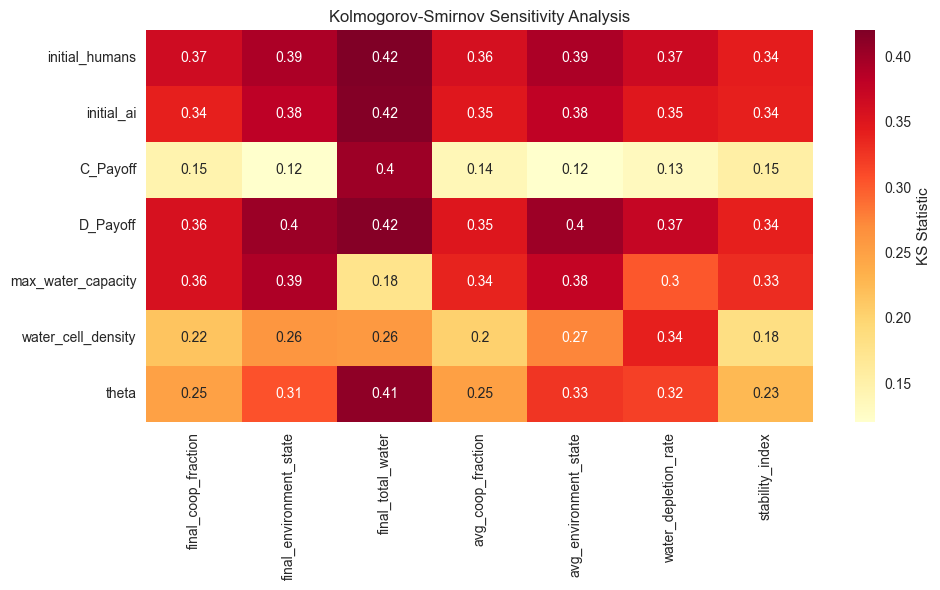

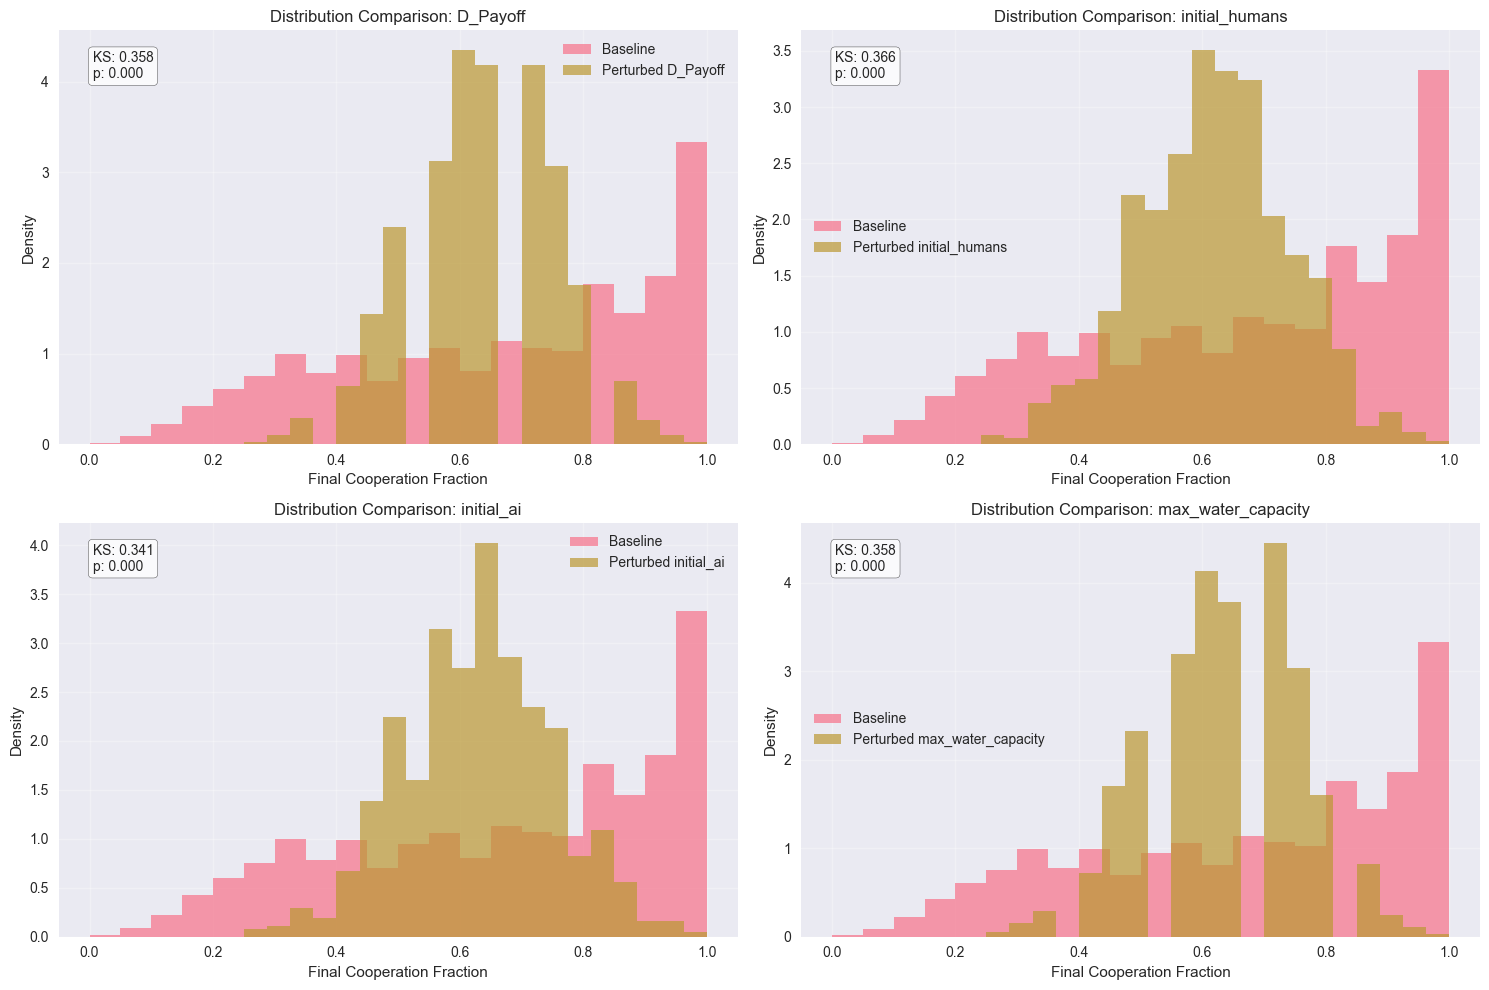

In [13]:
# Plot KS sensitivity results
analyzer.plot_ks_results(ks_results)

# Create distribution comparison plots for top sensitive parameters
top_params = ks_df.groupby('Parameter')['KS_Statistic'].mean().nlargest(4).index

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, param in enumerate(top_params):
    ax = axes[i]
    
    if param in ks_results:
        baseline_data = ks_results[param]['baseline_data']['final_coop_fraction'].dropna()
        perturbed_data = ks_results[param]['perturbed_data']['final_coop_fraction'].dropna()
        
        # Plot distributions
        ax.hist(baseline_data, alpha=0.7, label='Baseline', bins=20, density=True)
        ax.hist(perturbed_data, alpha=0.7, label=f'Perturbed {param}', bins=20, density=True)
        
        # Add KS statistic
        if param in ks_results and 'final_coop_fraction' in ks_results[param]['ks_tests']:
            ks_stat = ks_results[param]['ks_tests']['final_coop_fraction']['ks_statistic']
            p_val = ks_results[param]['ks_tests']['final_coop_fraction']['p_value']
            ax.text(0.05, 0.95, f'KS: {ks_stat:.3f}\np: {p_val:.3f}', 
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax.set_xlabel('Final Cooperation Fraction')
        ax.set_ylabel('Density')
        ax.set_title(f'Distribution Comparison: {param}')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Comprehensive (Hybrid) Report**

Comprehensive Sensitivity Analysis Report:
            Parameter  OAT_Avg_Range  OAT_Avg_Correlation  Sobol_Avg_S1  \
5  water_cell_density     176.855541             0.783437      0.019089   
4  max_water_capacity     163.920150             0.511318      0.013795   
2            C_Payoff      35.477167             0.900722     -0.006666   
0      initial_humans      12.685467             0.474429      0.009164   
1          initial_ai      12.685467             0.474429      0.002889   
6               theta       8.763078             0.556005      0.018372   
3            D_Payoff       2.486480             0.005173      0.021329   

   Sobol_Avg_ST  KS_Avg_Statistic  Overall_Sensitivity  
5      0.100182          0.247986            59.067903  
4      0.102189          0.324700            54.782347  
2      0.088072          0.173429            11.912889  
0      0.091457          0.377286             4.384737  
1      0.089206          0.365271             4.379982  
6      0.10034

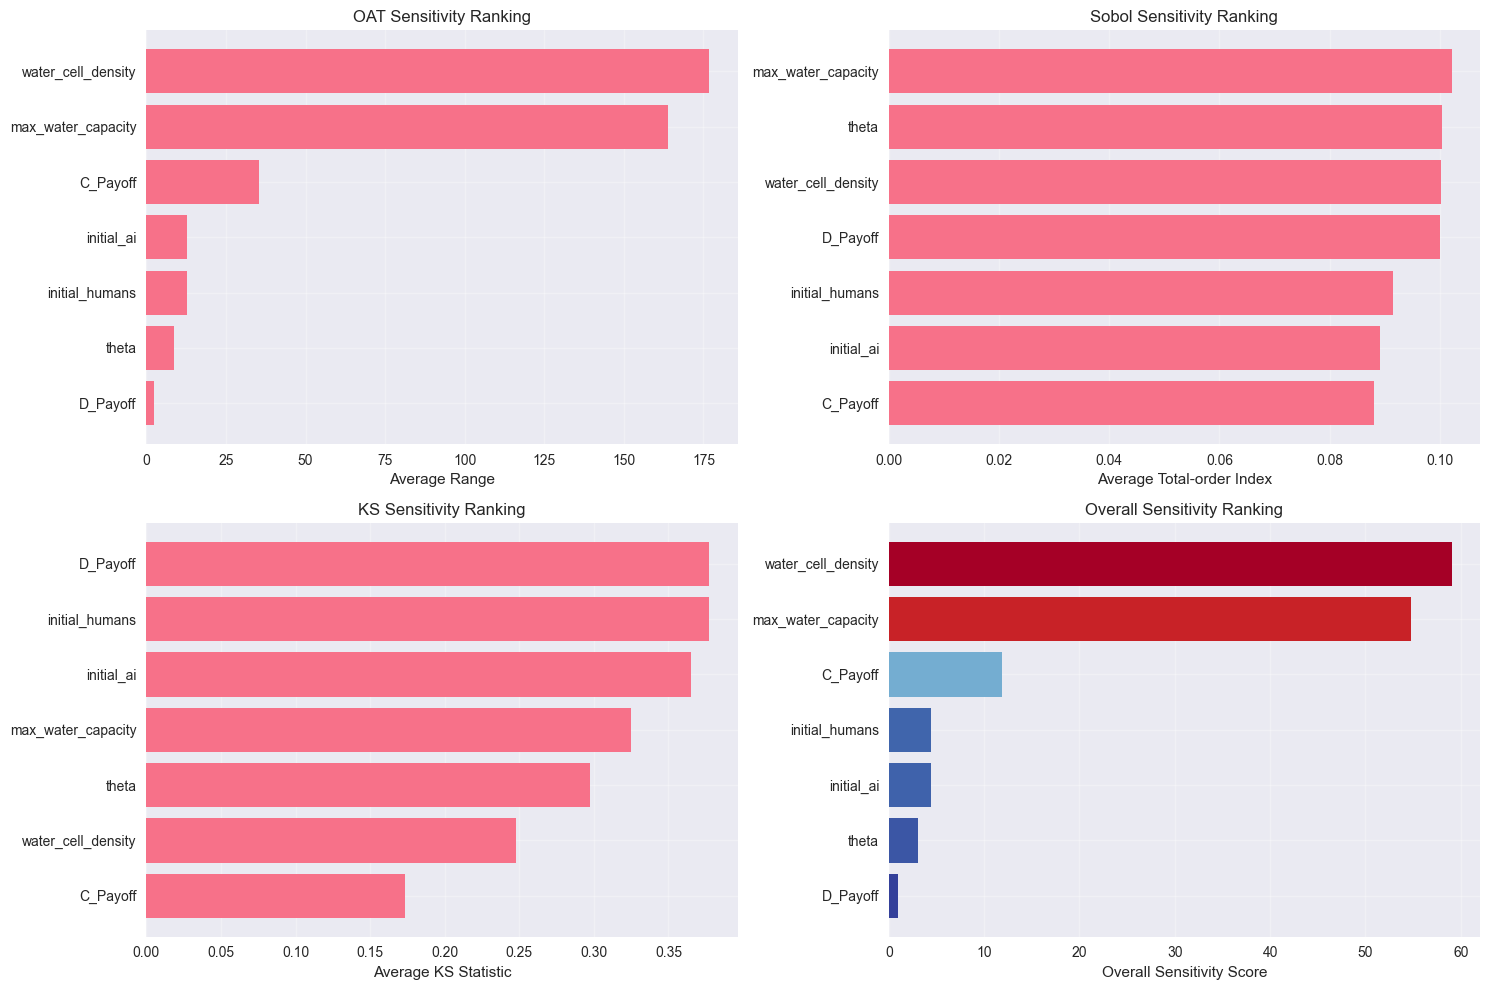

In [14]:
# Generate comprehensive sensitivity report
report = analyzer.generate_sensitivity_report(oat_results, sobol_results, ks_results)

print("Comprehensive Sensitivity Analysis Report:")
print("="*50)
print(report)

# Create comprehensive ranking visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# OAT ranking
ax1 = axes[0, 0]
oat_rank = report.sort_values('OAT_Avg_Range', ascending=True)
bars = ax1.barh(oat_rank['Parameter'], oat_rank['OAT_Avg_Range'])
ax1.set_xlabel('Average Range')
ax1.set_title('OAT Sensitivity Ranking')
ax1.grid(True, alpha=0.3)

# Sobol ranking
ax2 = axes[0, 1]
sobol_rank = report.sort_values('Sobol_Avg_ST', ascending=True)
bars = ax2.barh(sobol_rank['Parameter'], sobol_rank['Sobol_Avg_ST'])
ax2.set_xlabel('Average Total-order Index')
ax2.set_title('Sobol Sensitivity Ranking')
ax2.grid(True, alpha=0.3)

# KS ranking
ax3 = axes[1, 0]
ks_rank = report.sort_values('KS_Avg_Statistic', ascending=True)
bars = ax3.barh(ks_rank['Parameter'], ks_rank['KS_Avg_Statistic'])
ax3.set_xlabel('Average KS Statistic')
ax3.set_title('KS Sensitivity Ranking')
ax3.grid(True, alpha=0.3)

# Overall ranking
ax4 = axes[1, 1]
overall_rank = report.sort_values('Overall_Sensitivity', ascending=True)
colors = plt.cm.RdYlBu_r(overall_rank['Overall_Sensitivity'] / overall_rank['Overall_Sensitivity'].max())
bars = ax4.barh(overall_rank['Parameter'], overall_rank['Overall_Sensitivity'], color=colors)
ax4.set_xlabel('Overall Sensitivity Score')
ax4.set_title('Overall Sensitivity Ranking')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Method Comparison (Rankings - 1 = most sensitive):
                    OAT_Rank  Sobol_Rank  KS_Rank  Overall_Rank
Parameter                                                      
water_cell_density         1           3        6             1
max_water_capacity         2           1        4             2
C_Payoff                   3           7        7             3
initial_humans             4           5        2             4
initial_ai                 4           6        3             5
theta                      6           2        5             6
D_Payoff                   7           4        1             7


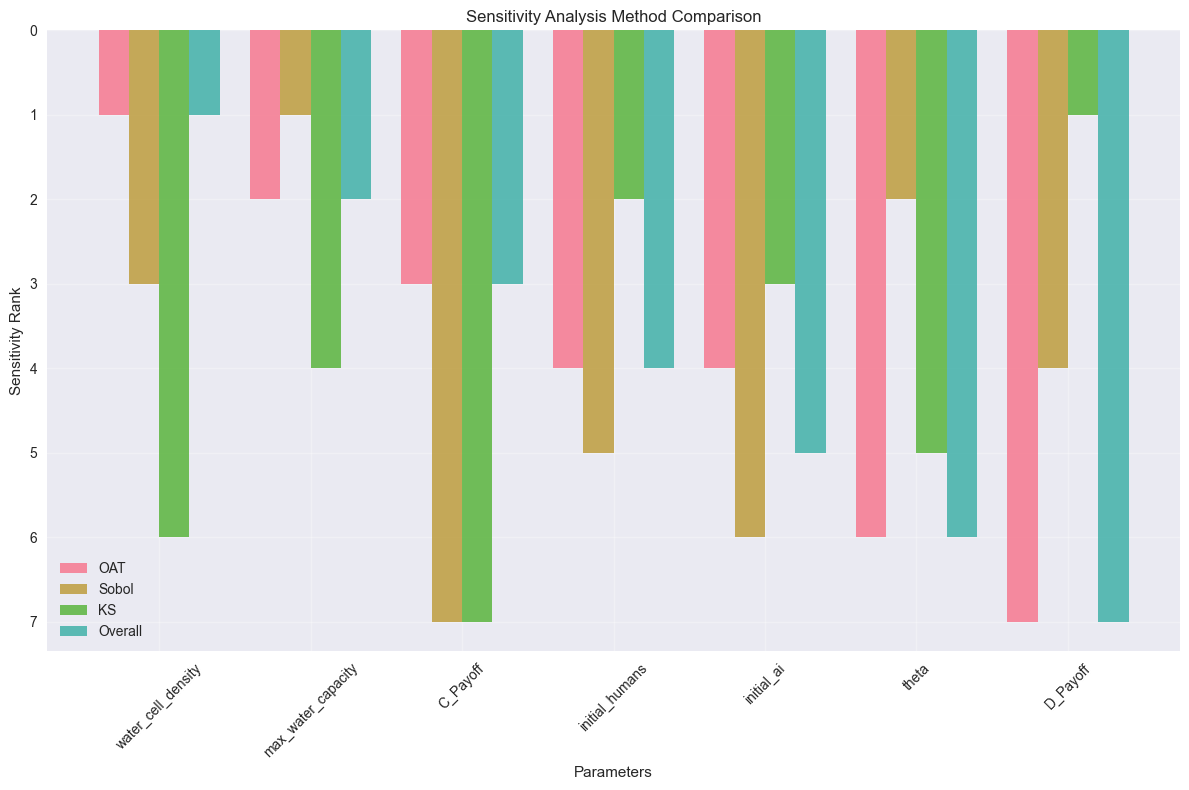


Rank Correlations Between Methods:
      Method1     Method2  Correlation   P_Value
0    OAT_Rank  Sobol_Rank     0.126131  0.787572
1    OAT_Rank     KS_Rank    -0.630656  0.128888
2  Sobol_Rank     KS_Rank     0.035714  0.939408


In [15]:
# Compare rankings across methods
comparison_data = []
for _, row in report.iterrows():
    param = row['Parameter']
    
    # Get rankings (1 = most sensitive)
    oat_rank = report['OAT_Avg_Range'].rank(ascending=False)[report['Parameter'] == param].iloc[0]
    sobol_rank = report['Sobol_Avg_ST'].rank(ascending=False)[report['Parameter'] == param].iloc[0]
    ks_rank = report['KS_Avg_Statistic'].rank(ascending=False)[report['Parameter'] == param].iloc[0]
    overall_rank = report['Overall_Sensitivity'].rank(ascending=False)[report['Parameter'] == param].iloc[0]
    
    comparison_data.append({
        'Parameter': param,
        'OAT_Rank': int(oat_rank),
        'Sobol_Rank': int(sobol_rank),
        'KS_Rank': int(ks_rank),
        'Overall_Rank': int(overall_rank)
    })

comparison_df = pd.DataFrame(comparison_data).set_index('Parameter')

print("Method Comparison (Rankings - 1 = most sensitive):")
print(comparison_df)

# Visualize ranking comparison
plt.figure(figsize=(12, 8))
x = np.arange(len(comparison_df))
width = 0.2

plt.bar(x - 1.5*width, comparison_df['OAT_Rank'], width, label='OAT', alpha=0.8)
plt.bar(x - 0.5*width, comparison_df['Sobol_Rank'], width, label='Sobol', alpha=0.8)
plt.bar(x + 0.5*width, comparison_df['KS_Rank'], width, label='KS', alpha=0.8)
plt.bar(x + 1.5*width, comparison_df['Overall_Rank'], width, label='Overall', alpha=0.8)

plt.xlabel('Parameters')
plt.ylabel('Sensitivity Rank')
plt.title('Sensitivity Analysis Method Comparison')
plt.xticks(x, comparison_df.index, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().invert_yaxis()  # Lower rank = more sensitive
plt.tight_layout()
plt.show()

# Calculate rank correlation between methods
from scipy.stats import spearmanr

methods = ['OAT_Rank', 'Sobol_Rank', 'KS_Rank']
correlations = []

for i in range(len(methods)):
    for j in range(i+1, len(methods)):
        corr, p_val = spearmanr(comparison_df[methods[i]], comparison_df[methods[j]])
        correlations.append({
            'Method1': methods[i],
            'Method2': methods[j],
            'Correlation': corr,
            'P_Value': p_val
        })

corr_df = pd.DataFrame(correlations)
print("\nRank Correlations Between Methods:")
print(corr_df)

KEY INSIGHTS FROM SENSITIVITY ANALYSIS
Most sensitive parameters: water_cell_density, max_water_capacity, C_Payoff
Parameters consistently ranked high across all methods: 
Theta (environmental feedback) overall ranking: 6
Cooperation payoff ranking: 3, Defection payoff ranking: 7


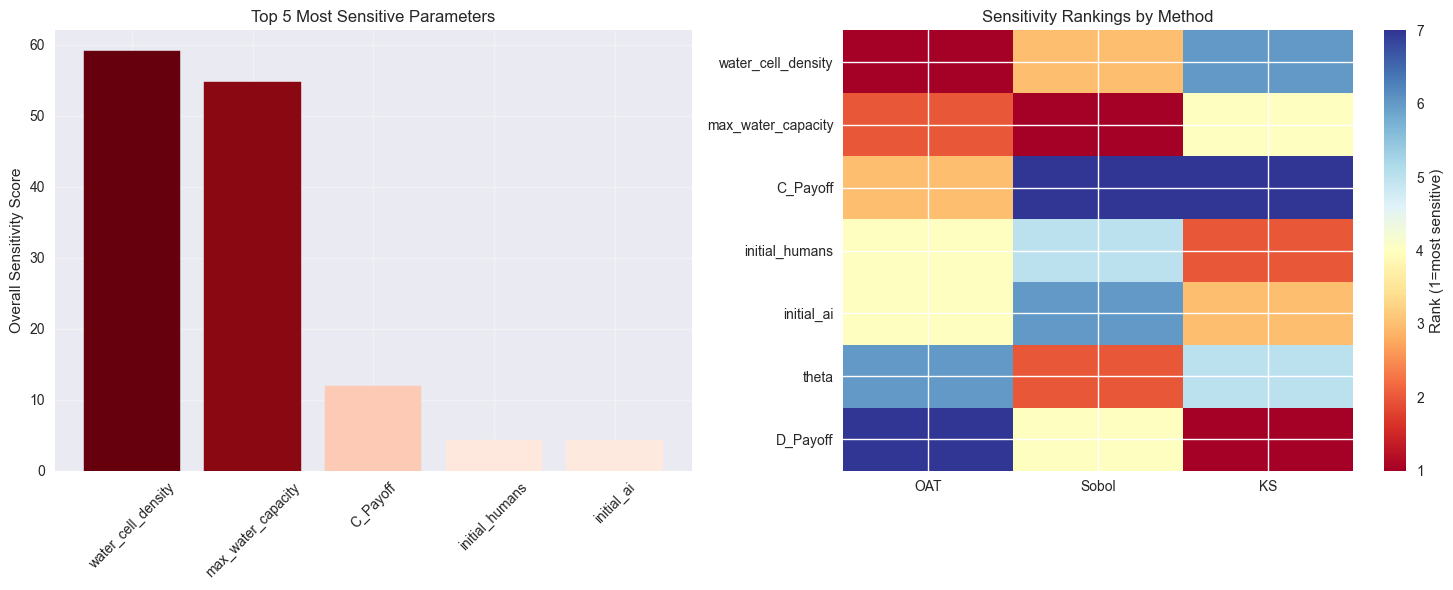

In [16]:
# Generate key insights
print("KEY INSIGHTS FROM SENSITIVITY ANALYSIS")
print("="*50)

# Most sensitive parameters
top_3_params = report.nlargest(3, 'Overall_Sensitivity')['Parameter'].tolist()
print(f"Most sensitive parameters: {', '.join(top_3_params)}")

# Method agreement
high_agreement = comparison_df[
    (comparison_df['OAT_Rank'] <= 3) & 
    (comparison_df['Sobol_Rank'] <= 3) & 
    (comparison_df['KS_Rank'] <= 3)
].index.tolist()

print(f"Parameters consistently ranked high across all methods: {', '.join(high_agreement)}")

# Environmental feedback importance
theta_ranking = comparison_df.loc['theta', 'Overall_Rank']
print(f"Theta (environmental feedback) overall ranking: {theta_ranking}")

# Cooperation vs defection payoff importance
if 'C_Payoff' in comparison_df.index and 'D_Payoff' in comparison_df.index:
    c_rank = comparison_df.loc['C_Payoff', 'Overall_Rank']
    d_rank = comparison_df.loc['D_Payoff', 'Overall_Rank']
    print(f"Cooperation payoff ranking: {c_rank}, Defection payoff ranking: {d_rank}")

# Create final summary visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Sensitivity summary
top_params = report.nlargest(5, 'Overall_Sensitivity')
bars = ax1.bar(range(len(top_params)), top_params['Overall_Sensitivity'])
ax1.set_xticks(range(len(top_params)))
ax1.set_xticklabels(top_params['Parameter'], rotation=45)
ax1.set_ylabel('Overall Sensitivity Score')
ax1.set_title('Top 5 Most Sensitive Parameters')
ax1.grid(True, alpha=0.3)

# Color bars by sensitivity level
colors = plt.cm.Reds(top_params['Overall_Sensitivity'] / top_params['Overall_Sensitivity'].max())
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Method agreement heatmap
method_agreement = np.zeros((len(comparison_df), len(methods)))
for i, param in enumerate(comparison_df.index):
    for j, method in enumerate(methods):
        method_agreement[i, j] = comparison_df.loc[param, method]

im = ax2.imshow(method_agreement, cmap='RdYlBu', aspect='auto')
ax2.set_xticks(range(len(methods)))
ax2.set_xticklabels([m.replace('_Rank', '') for m in methods])
ax2.set_yticks(range(len(comparison_df)))
ax2.set_yticklabels(comparison_df.index)
ax2.set_title('Sensitivity Rankings by Method')
plt.colorbar(im, ax=ax2, label='Rank (1=most sensitive)')

plt.tight_layout()
plt.show()